In [1]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss
from statsmodels.stats.outliers_influence import variance_inflation_factor
#import dask.dataframe as dd

In [2]:
#read in members and train datafiles
members = pd.read_csv(r'E:\KKbox\members_v3.csv')
train = pd.read_csv(r'E:\KKbox\train_v2.csv')
#create training dataframe 
train = train.merge(members,how='left',on=['msno'])

In [3]:
# read in first 50 million rows of user logs file
user_logs = pd.read_csv(r'E:\KKbox\user_logs_v2.csv')
user_logs= pd.concat((user_logs,pd.read_csv(r'E:\KKbox\user_logs.csv',nrows=50000000)), axis=0, ignore_index=True).reset_index(drop=True)
user_logs['date'] = pd.to_datetime(user_logs['date'],format='%Y%m%d')
#select only logs for users that are in df
msnos = train['msno']
relevant_user_logs = user_logs.loc[user_logs['msno'].isin(msnos)]
user_logs = pd.DataFrame(index=[],columns=[])

In [4]:
#select only logs for the last two months before the churn window, which for the train set is March 2017
LastTwoMonthslogs = relevant_user_logs.loc[(relevant_user_logs['date']<'2017-03-01') & (relevant_user_logs['date']>'2016-12-31')]
relevant_user_logs = pd.DataFrame(index=[],columns=[])

In [5]:
#aggregate the logs by mean so you can have one row of log info per user
mean_user_logs = pd.DataFrame(index=[],columns=[])
mean_user_logs['num_25'] = LastTwoMonthslogs.groupby('msno')['num_25'].mean()
mean_user_logs['num_50'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_75'] = LastTwoMonthslogs.groupby('msno')['num_75'].mean()
mean_user_logs['num_985'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_100'] = LastTwoMonthslogs.groupby('msno')['num_100'].mean()
mean_user_logs['num_unq'] = LastTwoMonthslogs.groupby('msno')['num_unq'].mean()
mean_user_logs['total_secs'] = LastTwoMonthslogs.groupby('msno')['total_secs'].mean()
mean_user_logs['days_logged'] = LastTwoMonthslogs.groupby('msno')['date'].count()

In [6]:
#merge the mean log data into the dataframe
mean_user_logs = mean_user_logs.reset_index()
train = train.merge(mean_user_logs,how='left',on='msno')

In [7]:
#read in transactions data, manipulate it to create feature for number of transactions, then clear memory and add data of the 
#most recent transaction to the training dataframe
transactions = pd.read_csv(r'E:\KKbox\transactions.csv', usecols=['msno'])
transactions = pd.concat((transactions, pd.read_csv(r'E:\KKbox\transactions_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','num_transactions']
train = pd.merge(train, transactions, how='left', on='msno')
transactions = []
transactions = pd.read_csv(r'E:\KKbox\transactions_v2.csv')
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')
train = pd.merge(train, transactions, how='left', on='msno')
transactions=[]

In [8]:
train= train.fillna(0)

In [9]:
#replace columns that have categorical data with dummy variables
train = pd.get_dummies(train,columns=['city','registered_via','gender'])

In [10]:
#check how many churners are in the dataframe relative to the size of the dataframe
print(train.is_churn.sum())
print(train.shape)

87330
(970960, 52)


In [11]:
train.msno.nunique()

970960

In [12]:
#can optionally subset the dataframe into churners and nonchurners and reconstruct with a higher ratio of churners in order to 
#produce a better trained model
churners= train.loc[train['is_churn']==1]
nonchurners= train.loc[train['is_churn']==0]
nonchurners= nonchurners.sample(n=107000)
morechurnersdf = pd.concat([churners,nonchurners])

In [13]:
#identify features and target variable for calculating VIF
y = train['is_churn']
X = train.drop(['is_churn','msno',],axis=1)

In [14]:
#split into train and test sets and initialize classifier
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state=21)

In [15]:
#train
rf= RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
#make predictions on test set
y_pred = rf.predict(X_test)

In [17]:
#check confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[174343   2371]
 [  2621  14857]]
             precision    recall  f1-score   support

          0       0.99      0.99      0.99    176714
          1       0.86      0.85      0.86     17478

avg / total       0.97      0.97      0.97    194192



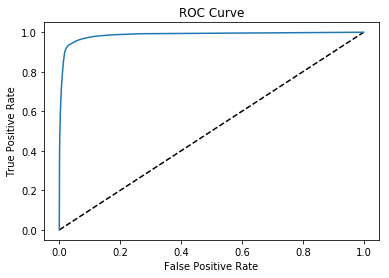

AUC: 0.9861211554440634
AUC scores computed using 5-fold cross-validation: [0.9853383  0.98439203 0.98587053 0.98677857 0.98513104]


In [18]:
#Check ROC curve, AUC score, and 5 fold cv AUC
y_pred_prob = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("AUC: {}".format(roc_auc_score(y_test, y_pred_prob)))
cv_auc = cross_val_score(rf,X,y,cv=5,scoring='roc_auc')
print("AUC scores computed using 5-fold cross-validation: {}".format(cv_auc))

In [19]:
c_space = np.logspace(-5, 8, 15)
param_grid = {'C':c_space, 'penalty': ['l1', 'l2']}
logreg_cv = GridSearchCV(logreg, param_grid, scoring='neg_log_loss',cv=5)
logreg_cv.fit(X,y)
print("Tuned Logistic Regression Parameters: {}".format(logreg_cv.best_params_)) 
print("Best score is {}".format(logreg_cv.best_score_))

NameError: name 'logreg' is not defined

In [20]:
#check log loss
log_loss(y_test,y_pred_prob)

0.09625370790222848

In [23]:
rf.feature_importances_
Features = pd.DataFrame()
Features['features'] = X.columns
Features['importance'] = np.transpose(rf.feature_importances_)
Features

,features,importance
0,bd,0.018262
1,registration_init_time,0.045327
2,num_25,0.014974
3,num_50,0.011007
4,num_75,0.011655
5,num_985,0.011086
6,num_100,0.015818
7,num_unq,0.015747
8,total_secs,0.016348
9,days_logged,0.007322


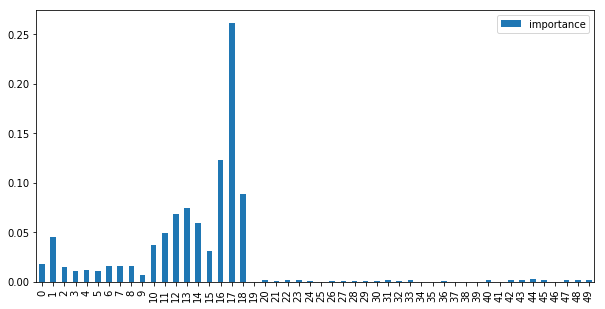

In [24]:
Features.plot(kind='bar',figsize=(10,5))

In [25]:
train = []
sample_submission = pd.read_csv(r'E:\KKbox\sample_submission_v2.csv')
test = sample_submission.merge(members,how='left',on=['msno'])

In [26]:
# read in first 50 million rows of user logs file
user_logs = pd.read_csv(r'E:\KKbox\user_logs_v2.csv')
user_logs= pd.concat((user_logs,pd.read_csv(r'E:\KKbox\user_logs.csv',nrows=50000000)), axis=0, ignore_index=True).reset_index(drop=True)
user_logs['date'] = pd.to_datetime(user_logs['date'],format='%Y%m%d')
#select only logs for users that are in df
msnos = test['msno']
relevant_user_logs = user_logs.loc[user_logs['msno'].isin(msnos)]
user_logs = pd.DataFrame(index=[],columns=[])

In [27]:
#The provided test set are for users churning in the next month after the train set
LastTwoMonthslogs = relevant_user_logs.loc[(relevant_user_logs['date']<'2017-04-01') & (relevant_user_logs['date']>'2017-01-31')]
relevant_user_logs = pd.DataFrame(index=[],columns=[])

In [28]:
mean_user_logs = pd.DataFrame(index=[],columns=[])
mean_user_logs['num_25'] = LastTwoMonthslogs.groupby('msno')['num_25'].mean()
mean_user_logs['num_50'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_75'] = LastTwoMonthslogs.groupby('msno')['num_75'].mean()
mean_user_logs['num_985'] = LastTwoMonthslogs.groupby('msno')['num_50'].mean()
mean_user_logs['num_100'] = LastTwoMonthslogs.groupby('msno')['num_100'].mean()
mean_user_logs['num_unq'] = LastTwoMonthslogs.groupby('msno')['num_unq'].mean()
mean_user_logs['total_secs'] = LastTwoMonthslogs.groupby('msno')['total_secs'].mean()
mean_user_logs['days_logged'] = LastTwoMonthslogs.groupby('msno')['date'].count()

In [29]:
mean_user_logs = mean_user_logs.reset_index()
test = test.merge(mean_user_logs,how='left',on='msno')

In [30]:
transactions = pd.read_csv(r'E:\KKbox\transactions.csv', usecols=['msno'])
transactions = pd.concat((transactions, pd.read_csv(r'E:\KKbox\transactions_v2.csv', usecols=['msno'])), axis=0, ignore_index=True).reset_index(drop=True)
transactions = pd.DataFrame(transactions['msno'].value_counts().reset_index())
transactions.columns = ['msno','num_transactions']
test = pd.merge(test, transactions, how='left', on='msno')
transactions = []
transactions = pd.read_csv(r'E:\KKbox\transactions_v2.csv')
transactions = transactions.sort_values(by=['transaction_date'], ascending=[False]).reset_index(drop=True)
transactions = transactions.drop_duplicates(subset=['msno'], keep='first')
test = pd.merge(test, transactions, how='left', on='msno')
transactions=[]

In [31]:
test= test.fillna(0)

In [32]:
test = pd.get_dummies(test,columns=['city','registered_via','gender'])
print(test.is_churn.sum())
print(test.shape)

0
(907471, 52)


In [33]:
Xsubmission = test.drop(['is_churn','msno'],axis=1)
ysubmissionprob =rf.predict_proba(Xsubmission)[:,1]

In [34]:
sample_submission['is_churn'] = ysubmissionprob

In [35]:
sample_submission

,msno,is_churn
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0.00
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0.00
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0.00
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0.00
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0.00
5,nu1jZ/flvSaXRg0U9Es+xmo2KlAXq/q+mhcWFStwm9w=,0.08
6,biDTtgK83fEWXJDaxzD1eh22dion/h3odeIbS7qJMmY=,0.02
7,k/8uwi/iM9LZmRAIWXLqpZY6ENomXAscwsQsh6PxcTw=,0.00
8,18rQ/746SjA6nBx325UsyhfsDhu4tK01FXFxHWZjw20=,0.02
9,2V13OCoWx6vqKr/ZzNmKFrmnC2FtR4SWMz5C5Hi02PY=,0.00


In [36]:
sample_submission.to_csv('submission.csv', index=False)